In [ ]:
# Commented out IPython magic to ensure Python compatibility.
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xvzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd /content  # Change this to the appropriate directory if needed
!pip install TA-Lib

!pip install swig
!pip install wrds
!pip install pyportfolioopt

## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

import finrl
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import os
import talib

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
get_ipython().run_line_magic('matplotlib', 'inline')
from finrl.config import INDICATORS

check_and_make_directories([TRAINED_MODEL_DIR])


import itertools

config_tickers.DOW_30_TICKER

# Function to calculate KDJ
def calculate_kdj(df, n=9, m1=3, m2=3):
    low_list = df['low'].rolling(n).min()
    high_list = df['high'].rolling(n).max()
    rsv = (df['close'] - low_list) / (high_list - low_list) * 100
    k_values = rsv.ewm(span=m1, adjust=False).mean()
    d_values = k_values.ewm(span=m2, adjust=False).mean()
    j_values = 3 * k_values - 2 * d_values
    return k_values, d_values, j_values

TRAIN_START_DATE = '2013-01-01' #start date of training data
TRAIN_END_DATE = '2018-01-01'   #end date of training data
TRADE_START_DATE = '2018-01-01' #start date of trading data
TRADE_END_DATE = '2022-12-31'   #end date of trading data

# fetching data from the Yahoo finance by giving the start and end date and the top 30 tickers
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

df_raw.head()

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
# Calculate KDJ and add to the dataframe
n = 9  # Period for calculating KDJ
m1 = 3  # Smoothing period for %K
m2 = 3  # Smoothing period for %D

k_values, d_values, j_values = calculate_kdj(processed_full, n, m1, m2)
processed_full['k_values'] = k_values
processed_full['d_values'] = d_values
processed_full['j_values'] = j_values

processed_full = processed_full.fillna(0)
processed_full.head()

#Spliting the data for training and trading
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

#saving the split data into csv file
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

train = pd.read_csv('train_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']

#Construct the environment
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,  # Maximum number of trading days in each episode
    "initial_amount": 1000000,  # Initial capital
    "num_stock_shares": num_stock_shares,  # List to track the number of shares held
    "buy_cost_pct": buy_cost_list,  # Buying cost percentages for each stock
    "sell_cost_pct": sell_cost_list,  # Selling cost percentages for each stock
    "state_space": state_space,  # Size and configuration of the state space
    "stock_dim": stock_dimension,  # Number of different stocks
    "tech_indicator_list": INDICATORS,  # List of technical indicators
    "action_space": stock_dimension,  # Size of the action space (number of stocks to buy/sell)
    "reward_scaling": 1e-4  # Scaling factor for rewards
}
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

#creating environment of training
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

#training DRL agents
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True
if_using_dqn = True


--2023-12-01 00:13:30--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-12-01 00:13:31--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://gigenet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-12-01 00:13:31--  http://gigenet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving gigenet.dl.sour

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:

# ### Agent 1: A2C

agent = DRLAgent(env = env_train)
A2C_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.01,
}

model_a2c = agent.get_model("a2c",model_kwargs = A2C_PARAMS)

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

# ### Agent 2: DDPG
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
    "buffer_size": 1000000,
    "learning_rate": 0.001,
    "batch_size": 256,
}
model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

#### Agent 3: PPO
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.01,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)


trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None


trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

# ### Agent 4: TD3
agent = DRLAgent(env = env_train)
TD3_PARAMS = {
    "buffer_size": 1000000,
    "learning_rate": 0.001,
    "batch_size": 256,
}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)



trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None



trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

# ### Agent 5: SAC

agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "buffer_size": 1000000,
    "learning_rate": 0.001,
    "batch_size": 256,
    "learning_starts": 100,

}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.01}
Using cpu device


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Logging to results/a2c
day: 1258, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 2692059.83
total_reward: 1692059.83
total_cost: 3760.65
total_trades: 20965
Sharpe: 1.530
day: 1258, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 2589637.30
total_reward: 1589637.30
total_cost: 1235.84
total_trades: 23016
Sharpe: 1.589
day: 1258, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 2508896.92
total_reward: 1508896.92
total_cost: 1507.28
total_trades: 22312
Sharpe: 1.571
day: 1258, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 2600079.34
total_reward: 1600079.34
total_cost: 1199.31
total_trades: 18842
Sharpe: 1.614
{'buffer_size': 1000000, 'learning_rate': 0.001, 'batch_size': 256}
Using cpu device
Logging to results/ddpg
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 46         |
|    time_elapsed    | 109        |
|    total_timesteps | 5036       |
| train/    

In [9]:


#backtesting
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

trained_a2c = A2C.load("trained_models/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load("trained_models/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load("trained_models/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load("trained_models/agent_td3") if if_using_td3 else None
trained_sac = SAC.load("trained_models/agent_sac") if if_using_sac else None

stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else (None, None)

df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else (None, None)

df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else (None, None)

df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym) if if_using_td3 else (None, None)

df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym) if if_using_sac else (None, None)

def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['dji']).fetch_data()
# df_dji

df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')
# dji

df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Stock Dimension: 29, State Space: 291
hit end!
hit end!
hit end!
hit end!
hit end!
Mean returns of assets in k-portfolio 1
 [ 0.08   0.074  0.055  0.126  0.064  0.087  0.071  0.033  0.071  0.067
  0.101  0.083 -0.001  0.083  0.069  0.088  0.032  0.068  0.087  0.044
  0.11   0.084  0.039  0.063  0.125  0.097  0.037  0.071  0.044]
Variance-Covariance matrix of returns
 [[2.257 0.596 0.399 0.528 0.647 0.71  0.593 0.436 0.443 0.661 0.434 0.545
  0.44  0.657 0.296 0.584 0.244 0.336 0.44  0.325 0.73  0.454 0.29  0.35
  0.468 0.558 0.258 0.518 0.288]
 [0.596 2.411 0.702 0.672 0.612 0.985 0.584 0.547 0.673 0.87  0.652 0.731
  0.493 0.691 0.695 0.841 0.34  0.422 0.567 0.865 0.624 0.651 0.46  0.506
  0.808 0.812 0.415 0.849 0.407]
 [0.399 0.702 1.493 0.601 0.644 0.71  0.48  0.48  0.536 0.89  0.503 0.606
  0.452 0.572 0.398 0.839 0.291 0.286 0.474 0.477 0.539 0.563 0.295 0.42
  0.511 0.709 0.328 0.54  0.288]
 [0.528 0.672 0.601 1.732 0.732 0.706 0.537 0.572 0.619 0.829 0.496 0.743
  0.533 0.6   0

<ipython-input-9-6586c756bbd6>:152: FutureWarning: Passing 'suffixes' which cause duplicate columns {'account_value_x'} in the result is deprecated and will raise a MergeError in a future version.
  if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)


In [7]:
col_name = []

col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None

col_name.append('Mean Var')

col_name.append('djia')

result.columns = col_name

result = result.round(2)

result





,A2C,Mean Var,djia
date,,,
2018-01-02,1000000.00,1001754.02,1000000.00
2018-01-03,999978.59,1007493.56,1003975.96
2018-01-04,1001443.06,1011830.50,1010115.20
2018-01-05,1009383.82,1032810.98,1019009.84
2018-01-08,1008567.46,1027843.82,1018490.17
...,...,...,...
2022-12-22,1516521.26,1820383.12,NaN
2022-12-23,1522867.94,1831324.56,NaN
2022-12-27,1524562.35,1831004.27,NaN


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

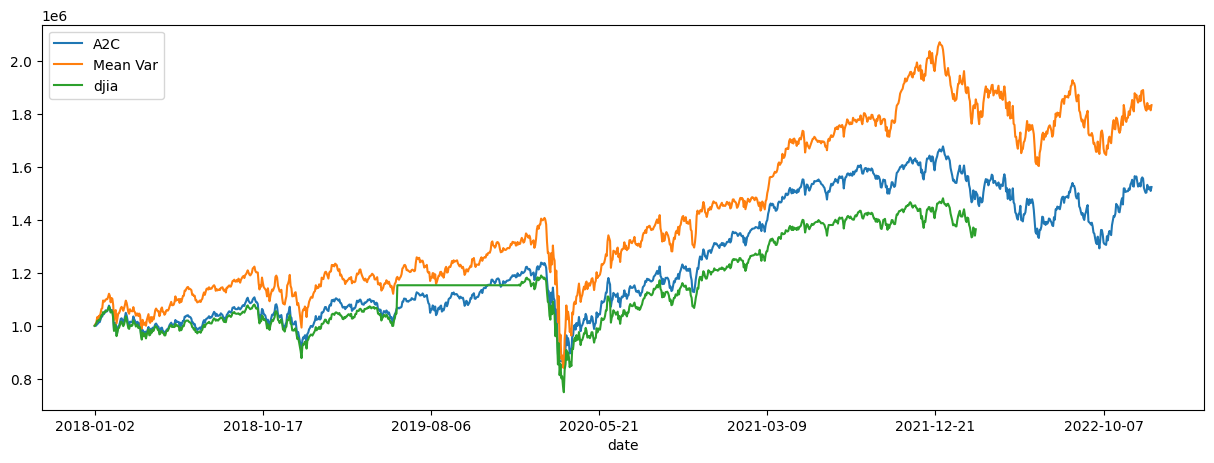

In [8]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()